In [1]:
using CSV, DataFrames, StatsPlots, BioSequences, FASTX, KernelDensity

In [2]:
function map2ref(ref::Vector{DNA}, genes)
    refpos = zeros(Int, length(ref))
    count = 0
    currentgene=""
    for (n,(g,base)) in enumerate(zip(genes,ref))
        if g ≠ currentgene
            count = 0
            currentgene = g
        end
        if base ≠ DNA_Gap
            count += 1
            refpos[n] = count
        end
    end
    refpos
end

function onlyY(bases)
    if all(x->x ∈ [DNA_C, DNA_T], bases)
        return true
    else
        return false
    end
end

function Yissynonymous(genes::Vector{AbstractString}, bases::Vector{DNA})
    syn = falses(length(bases))
    codonbases = DNA[]
    gene = ""
    for (i,(g, b)) in enumerate(zip(genes, bases))
        if g ≠ gene
            empty!(codonbases)
            gene = g
        end
        if b ≠ DNA_Gap
            push!(codonbases, b)
        end
        if length(codonbases) == 3
            codon = LongDNA{4}(codonbases)
            aa = BioSequences.translate(codon)[1]
            for codonposition in 1:3
                codon = LongDNA{4}(codonbases)
                issyn = true
                codon[codonposition] = DNA_C
                if BioSequences.translate(codon)[1] ≠ aa
                    issyn = false
                end
                codon[codonposition] = DNA_T
                if BioSequences.translate(codon)[1] ≠ aa
                    issyn = false
                end
                syn[i-3+codonposition] = issyn
            end
            empty!(codonbases)
        end
    end
    syn
end

function parse_uid(uid::AbstractString)
    m = match(r"([A-Za-z0-9]+)e([C|U])([0-9]+)", uid)
    gene = m.captures[1]
    type = first(m.captures[2])
    refpos = parse(Int, m.captures[3])
    gene, type, refpos
end

function differs_by_mutation(edittype::Char, dna::Vector{DNA}, editing::BitVector)
    for (d, e) in zip(dna, editing)
        if edittype == 'U'
            if (d == DNA_C && ~e)
                return false
            end
        elseif (d == DNA_T && ~e)
            return false
        end
    end
    true
end

differs_by_mutation (generic function with 1 method)

In [3]:
function read_sites(organelle::String)
    genes = AbstractString[]
    species = ["Af", "Ap", "Ar", "Sm", "Mm"]
    sequences = Dict{String, LongDNA{4}}()
    for s in species
        sequences[s] = LongDNA{4}()
    end
    geneoffsets = [0]

    for filename in sort(filter(x->endswith(x, ".aln"), readdir("../data/$organelle/alignments"; join = true)))
        gene = first(split(basename(filename), "."))
        FASTA.Reader(open(filename)) do alnfile
            for (n, record) in enumerate(alnfile)
                seq = sequence(LongDNA{4}, record)
                push!(geneoffsets, last(geneoffsets)+length(seq))
                if n == 1
                    append!(genes, fill(gene, length(seq)))
                end
                sequences[identifier(record)] = append!(sequences[identifier(record)], seq)
            end
        end
    end

    df = DataFrame(pos=collect(1:length(genes)),gene=genes,Af=collect(sequences["Af"]),Ap=collect(sequences["Ap"]),Ar=collect(sequences["Ar"]),Sm=collect(sequences["Sm"]),Mm=collect(sequences["Mm"]))
    df.refpos = map2ref(df.Af, genes)

    synAf = Yissynonymous(df.gene, df.Af)
    synAp = Yissynonymous(df.gene, df.Ap)
    synAr = Yissynonymous(df.gene, df.Ar)
    synSm = Yissynonymous(df.gene, df.Sm)
    synMm = Yissynonymous(df.gene, df.Mm)

    df.Yissynonymous = synAf .& synAp .& synAr .& synSm .& synMm

    df.onlyY = onlyY.(eachrow(df[:,3:7]))
    filter!(x->x.onlyY, df)
    println("$(nrow(df)) DNA sites considered")

    #add editing sites
    df.editsite = falses(nrow(df))
    df.edittype = fill('.', nrow(df))
    df.creates_start = falses(nrow(df))
    df.creates_stop = falses(nrow(df))
    df.removes_stop = falses(nrow(df))
    df.editing_differs_by_mutation = trues(nrow(df))
    editing_sites = CSV.File("../data/$organelle/edit_sites/all_$organelle" * "_sites.tsv") |> DataFrame
    for site in eachrow(editing_sites)
        gene, type, refpos = parse_uid(site.uid)
        if nrow(df[(df.gene .== gene) .& (df.refpos .== refpos), :]) == 0
            continue
        end
        df[(df.gene .== gene) .& (df.refpos .== refpos), :editsite] .= true
        df[(df.gene .== gene) .& (df.refpos .== refpos), :edittype] .= type
        dna = first(df[(df.gene .== gene) .& (df.refpos .== refpos), :])
        df[(df.gene .== gene) .& (df.refpos .== refpos), :editing_differs_by_mutation] .= differs_by_mutation(type, [dna.Af,dna.Ar,dna.Ap,dna.Sm,dna.Mm], .~ismissing.([site.af,site.ar,site.ap,site.sm,site.mm]))
        df[(df.gene .== gene) .& (df.refpos .== refpos), :creates_start] .= site.creates_start
        df[(df.gene .== gene) .& (df.refpos .== refpos), :creates_stop] .= site.creates_stop
        df[(df.gene .== gene) .& (df.refpos .== refpos), :removes_stop] .= site.removes_stop
    end
    filter!(x->x.editsite || x.Yissynonymous, df)
    filter!(x->x.editing_differs_by_mutation, df)

    println("$(nrow(df)) sites retained, of which $(sum(df.editsite)) sites are edited")
    df
end


read_sites (generic function with 1 method)

In [4]:
cp = read_sites("cp")
mt = read_sites("mt")
sites = vcat(cp, mt)

31516 DNA sites considered
12140 sites retained, of which 690 sites are edited
15684 DNA sites considered
7672 sites retained, of which 2190 sites are edited


Row,pos,gene,Af,Ap,Ar,Sm,Mm,refpos,Yissynonymous,onlyY,editsite,edittype,creates_start,creates_stop,removes_stop,editing_differs_by_mutation
,Int64,Abstract…,DNA,DNA,DNA,DNA,DNA,Int64,Bool,Bool,Bool,Char,Bool,Bool,Bool,Bool
1,2,accD,T,C,T,C,C,2,false,true,true,U,true,false,false,true
2,6,accD,T,T,T,T,T,6,true,true,false,.,false,false,false,true
3,21,accD,T,T,T,T,T,21,true,true,false,.,false,false,false,true
4,27,accD,T,T,T,T,T,27,true,true,false,.,false,false,false,true
5,33,accD,C,C,C,T,C,33,true,true,false,.,false,false,false,true
6,42,accD,T,T,T,T,T,42,true,true,false,.,false,false,false,true
7,51,accD,C,C,C,C,C,51,true,true,false,.,false,false,false,true
8,60,accD,T,T,T,T,T,60,true,true,false,.,false,false,false,true
9,63,accD,T,T,T,T,T,63,true,true,false,.,false,false,false,true


In [5]:
unedited_partition = sites.edittype .== '.'
println("unedited_partition: $(sum(unedited_partition)) sites")

C2U_partition = sites.edittype .== 'U'
println("C2U_partition: $(sum(C2U_partition)) sites")
synC2U_partition = (sites.edittype .== 'U') .& sites.Yissynonymous
println("synC2U_partition: $(sum(synC2U_partition)) sites")
nonsynC2U_partition = (sites.edittype .== 'U') .& (.~sites.Yissynonymous)
println("nonsynC2U_partition: $(sum(nonsynC2U_partition)) sites")
senseC2U_partition = (sites.edittype .== 'U') .& (.~sites.Yissynonymous) .& (.~sites.creates_start)
println("senseC2U_partition: $(sum(senseC2U_partition)) sites")
creates_start_partition = sites.creates_start
println("creates_start_partition: $(sum(creates_start_partition)) sites")

U2C_partition = sites.edittype .== 'C'
println("U2C_partition: $(sum(U2C_partition)) sites")
synU2C_partition = (sites.edittype .== 'C') .& sites.Yissynonymous
println("synU2C_partition: $(sum(synU2C_partition)) sites")
nonsynU2C_partition = (sites.edittype .== 'C') .& .~sites.Yissynonymous
println("nonsynU2C_partition: $(sum(nonsynU2C_partition)) sites")
senseU2C_partition = (sites.edittype .== 'C') .& (.~sites.Yissynonymous) .& (.~sites.removes_stop)
println("senseU2C_partition: $(sum(senseU2C_partition)) sites")
removes_stop_partition = (sites.edittype .== 'C') .& sites.removes_stop
println("removes_stop_partition: $(sum(removes_stop_partition)) sites")


unedited_partition: 16932 sites
C2U_partition: 1980 sites
synC2U_partition: 151 sites
nonsynC2U_partition: 1829 sites
senseC2U_partition: 1772 sites
creates_start_partition: 57 sites
U2C_partition: 900 sites
synU2C_partition: 3 sites
nonsynU2C_partition: 897 sites
senseU2C_partition: 519 sites
removes_stop_partition: 378 sites


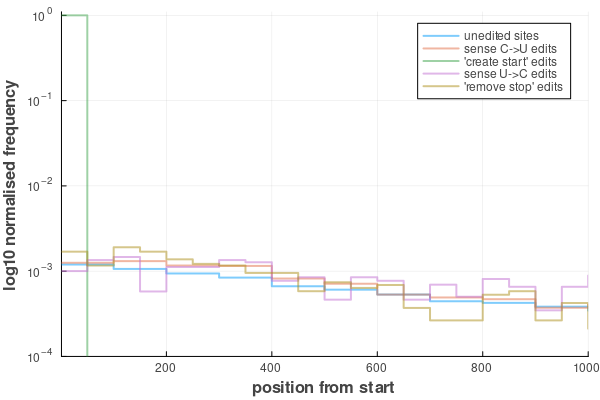

In [6]:
plot(;xlims = (1,1000), xguide = "position from start", ylims = (1e-4, 1.1), yguide = "log10 normalised frequency", yscale = :log10,
     fontfamily = "Helvetica", guidefontfamily = "Helvetica Bold")
plot!(sites.refpos[unedited_partition]; bins = 100, norm=true, seriestype = :stephist, lw = 2, alpha = 0.5, label = "unedited sites")
plot!(sites.refpos[senseC2U_partition]; bins = 100, norm=true, seriestype = :stephist, lw = 2, alpha = 0.5, label = "sense C->U edits")
plot!([1,50, 50],[1.0,1.0, 1e-4]; lw = 2, alpha = 0.5, label = "'create start' edits")
plot!(sites.refpos[senseU2C_partition]; bins = 100, norm=true, seriestype = :stephist, lw = 2, alpha = 0.5, label = "sense U->C edits")
plot!(sites.refpos[removes_stop_partition]; bins = 100, norm=true, seriestype = :stephist, lw = 2, alpha = 0.5, label = "'remove stop' edits")

In [7]:
savefig("edit_site_positions.svg")

"/Users/ian/Documents/projects/waterferns/waterfern_editing/code/edit_site_positions.svg"

In [8]:
mt_sense = mt.refpos[(mt.edittype .== 'U') .& (.~mt.Yissynonymous) .& (.~mt.creates_start), :]
count(mt_sense .< 40)

38

In [9]:
cp_sense = cp.refpos[(cp.edittype .== 'U') .& (.~cp.Yissynonymous) .& (.~cp.creates_start), :]
count(cp_sense .< 40)

25